In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [3]:
data_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
download_url(data_url, '.')

Using downloaded and verified file: .\cifar-10-python.tar.gz


In [4]:
import tarfile
with tarfile.open('./cifar-10-python.tar.gz', 'r:gz') as file:
    file.extractall(path='./data')

In [5]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
batch_size = 64
learning_rate = 0.001

In [7]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# print(train_dataset.__dict__)
classes = tuple(train_dataset.classes)

In [9]:
print(classes)

('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [10]:
print(train_dataset.data.shape)

means = [round(i, 4) for i in (train_dataset.data.mean(axis=(0, 1, 2))/255).tolist()]
stds = [round(i, 4) for i in (train_dataset.data.std(axis=(0, 1, 2))/255).tolist()]
print(f"Norm means: {means}, Std. : {stds}")

(50000, 32, 32, 3)
Norm means: [0.4914, 0.4822, 0.4465], Std. : [0.247, 0.2435, 0.2616]


In [11]:
transforms_comp = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tuple(means), tuple(stds))]
)

In [12]:
# train_dataset = DataLoader(dataset=datasets.CIFAR10(root='./data', train=True, transform=transforms_comp, download=True), batch_size=batch_size)
# test_dataset = DataLoader(dataset=datasets.CIFAR10(root='./data', train=False, transform=transforms_comp, download=True), batch_size=batch_size)

In [13]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_comp)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_comp)


val_size = 10000
train_size = len(train_dataset) - val_size
train_ds, val_dataset = random_split(train_dataset, [train_size, val_size])
# train_ds.__dict__
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
def imshow(img):
     img = img / 2.5 + 0.45 # unnormalize
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()

In [15]:
images, labels = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


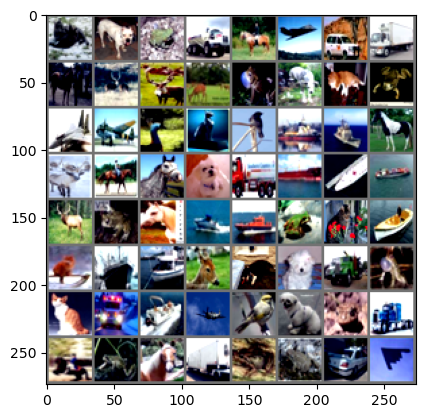

In [16]:
imshow(torchvision.utils.make_grid(images))

In [17]:
print(images.shape)

torch.Size([64, 3, 32, 32])


### Model

In [26]:
class ConvNet(nn.Module):
    """
    Convolutional Neural Network
    """
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [27]:
model = ConvNet(num_classes=10).to(device)

In [28]:
epochs = 6

train_steps = len(train_loader)
valid_steps = len(val_loader)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    "loss": [], 
    "accuracy": [], 
    "val_loss": [], 
    "val_accuracy": []
}

In [29]:
print(train_steps)

625


In [30]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
for epoch in range(epochs):
    train_losses = []
    valid_losses = []
    model.train()
    num_correct = 0
    num_samples = 0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_samples += correct.shape[0]
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.data.item())
        if (i+1) % 300 == 0:
            print(f"epoch {epoch + 1} / {epochs}, step {i + 1} / {train_steps}, loss = {loss.item():.4f}")

    accuracy = num_correct / num_samples if num_samples > 0 else 0
    print(f"epoch {epoch + 1}, accuracy = {accuracy}")
    model.eval()
    train_loss = torch.mean(torch.Tensor(train_losses)).item()
    metrics["loss"].append(train_loss)
    metrics["accuracy"].append(accuracy)

epoch 1 / 6, step 300 / 625, loss = 1.6619
epoch 1 / 6, step 600 / 625, loss = 1.3545
epoch 1, accuracy = 0.342075
epoch 2 / 6, step 300 / 625, loss = 1.2900
epoch 2 / 6, step 600 / 625, loss = 1.2203
epoch 2, accuracy = 0.5275
epoch 3 / 6, step 300 / 625, loss = 1.1022
epoch 3 / 6, step 600 / 625, loss = 0.9626
epoch 3, accuracy = 0.61025
epoch 4 / 6, step 300 / 625, loss = 0.9393
epoch 4 / 6, step 600 / 625, loss = 0.9094
epoch 4, accuracy = 0.6559
epoch 5 / 6, step 300 / 625, loss = 0.8017
epoch 5 / 6, step 600 / 625, loss = 0.7509
epoch 5, accuracy = 0.6946
epoch 6 / 6, step 300 / 625, loss = 0.7103
epoch 6 / 6, step 600 / 625, loss = 0.5731
epoch 6, accuracy = 0.717725


In [31]:
num_correct = 0
num_samples = 0
begin = time.time()
for (inputs, targets) in val_loader:
    optimizer.zero_grad()
    inputs = inputs.to(device)
    targets = targets.to(device)
    output = model(inputs)
    loss = loss_fn(output, targets)
    valid_losses.append(loss.data.item())
    correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_samples += correct.shape[0]

elasped_time = time.time() - begin
valid_loss = torch.mean(torch.Tensor(valid_losses)).item()
val_accuracy = num_correct / num_samples if num_samples > 0 else 0
metrics["val_loss"].append(valid_loss)
metrics["val_accuracy"].append(val_accuracy)


In [33]:
metrics

{'loss': [1.710639238357544,
  1.2928731441497803,
  1.0891929864883423,
  0.9617878198623657,
  0.8609879016876221,
  0.7956695556640625],
 'accuracy': [0.342075, 0.5275, 0.61025, 0.6559, 0.6946, 0.717725],
 'val_loss': [0.8184555172920227],
 'val_accuracy': [0.7131]}

In [34]:
print(f'Validation Loss: {metrics["val_loss"][0]:.4f}, Validation Accuracy: {metrics["val_accuracy"][0]:.4f}')

Validation Loss: 0.8185, Validation Accuracy: 0.7131


### Model save

In [35]:
PATH = './cnn-model.pth'
torch.save(model.state_dict(), PATH)

### Pruning

In [82]:
import torch.nn.utils.prune as prune

In [83]:
def load_model(model, filepath, device):
    model.load_state_dict(torch.load(filepath, map_location=device))
    print(model)
    return model

In [84]:
def pruning(model, train_loader,
            test_loader,
            conv2d_prune_amt=0.5,
            num_iters=10,
            ):
    for i in range(num_iters):
        print(f"Pruning {i + 1} / {num_iters}")
        params_to_prune = []
        for module_name, module in model.named_modules():
            if isinstance(module, nn.Conv2d):
                params_to_prune.append((module, "weight"))
        prune.global_unstructured(params_to_prune,
                                  pruning_method=prune.L1Unstructured,
                                  amount=conv2d_prune_amt)
    num_correct = 0
    num_samples = 0
    begin = time.time()
    for (inputs, targets) in test_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)
        valid_losses.append(loss.data.item())
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_samples += correct.shape[0]
    valid_loss = torch.mean(torch.Tensor(valid_losses)).item()
    val_accuracy = num_correct / num_samples if num_samples > 0 else 0
    print(f"Accuracy {val_accuracy}")

In [85]:
un_model = ConvNet(num_classes=10)

p_model = load_model(model=un_model, filepath=PATH, device=device)

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, 

In [86]:
import copy
pruning_model = copy.deepcopy(p_model)

In [87]:
pruning_model = pruning_model.to(device)

In [91]:
pruning(pruning_model, 
        train_loader=train_loader,
        test_loader=val_loader,
        conv2d_prune_amt=0.7,
        num_iters=1,
        )

Pruning 1 / 1
Accuracy 0.6886
